# Autoencoder (AE)

Autoencoders map the inputs of the neural network to points of latent space. The dimensionality of the latent space is usually lower dimensional than the dimensionality of the input.

![alt text](https://qph.fs.quoracdn.net/main-qimg-3e7385084fb61e6b0288ad79a2440169.webp "Diagram indicating how the AutoEncoder works")

The MNIST dataset which consists out of images with the size 28x28 pixels. One image can be seen as a 28*28=784 dimensional vector, where each entry holds the value of a single pixel. The diagram above shows what the autoencoder does. It converts the full image, to a point in the 10 dimensional latent space (Encoder) and is able to recover the original image out of the latent representation.

Applications:
1. Compression ... As the latent space is smaller than the original input size, the latent representation can stored more efficiently.
2. Anomaly Detection ... If the input data used for autoencoders is considered "normal", the autoencoder learns all those normal features during training. If some input deviates from the norm (f.e. a handwritten "A" instead of a number in the example above), the autoencoder will perform worse in reconstructing the image.
3. Reducing Noise ... The model is trained on reconstructing noise-free images. So if noisy images get fed into the autoencoder, there is a high chance in resulting into a reconstruction with substantially less noise.

![alt text](https://miro.medium.com/max/1200/1*b0yK9lFB51T_fFXWmEoUoA.png "Example for Noise reduction on the MNIST dataset")

# Variational Autoencoder (VAE)

Regular autoencoders lack regularity in the latent space. There is relation in the distance between two points in the latent space to the similarity of the reconstructed images, the mapping is arbitrary.

This problem gets tackled by Variational Autoencoders. Instead of mapping the input to a specific point in the latent space, it maps it to a distribution of points. The output of the encoder is a normal distribution over the latent space that can be used to sample points in the same. That is exactly what happens during training, a point gets sampled from the distribution which is then fed into the decoder, which is identical to the regular autoencoder.

![alt text](https://miro.medium.com/max/700/1*Q5dogodt3wzKKktE0v3dMQ@2x.png "Diagram of a VAE")

The diagram above shows how the VAE is different to the regular AE. In addition to the squared difference between the reconstructed image and the original one (which is the error-measure in the regular AE), the Kullback-Leibler divergence is used to make the resulting distribution as regular as possible.

Thre result is a regular latent space, where a small distance between two points means a high similarity in the respective decoded images. As you can see in the image below, the images in the latent space transition smoothly between the distinct features the model was trained on. Initially, the model was trained on the features "Square", "Triangle", "Triangle with rounded edges" and "Circle" but in the final distribution there are is a smooth transition between for example "Triangle" and "Circles" with all levels "roundness".

![alt text](https://miro.medium.com/max/700/1*79AzftDm7WcQ9OfRH5Y-6g@2x.png "Diagram of a VAE")

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

latent_dim = 2 # dimensionality of the latent space
load = True    # should stored weights be loaded from the disk?
train = False  # should the model be trained? 
export = False # should the weights be exported? 

In [3]:
def plot_latent(encoder, decoder):
    '''
    Plots a grid of points in the latent space to check the seemless transition between features.
    '''
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.title('Distribution of images in the latent space')
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

In [4]:
def plot_label_clusters(encoder, decoder, data, labels):
    '''
    display a 2D plot of the digit classes in the latent space
    '''
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title('Visualization of the latent space')
    plt.show()


In [5]:
class Sampling(layers.Layer):
    '''
    Custom layer that samples a point in the latent space from the parameters
    of the target distribution. 
    '''

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]                                  # determine the size of the vector to sample out 
                                                                     # of the shape of the input neurons
        
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) # sample a vector with normal distributed values
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [6]:
class VAE(keras.Model):
    '''
    Represents one variational auto encoder. The main properties are the encoder and decoder
    which are used to translate input of MNIST data (28,28,1) to a variable latent space and
    back. A custom training step with loss function is implemented that combines the pixel-
    difference with the KL-value.
    '''
    
    def __init__(self, latent_dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        
        self.encoder = self.build_encoder(latent_dim)
        self.decoder = self.build_decoder(latent_dim)
    
    def build_decoder(self, latent_dim):
        '''
        Build the encoder network. 
        '''
        latent_inputs = keras.Input(shape=(latent_dim,))
        x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
        x = layers.Reshape((7, 7, 64))(x)
        x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
        decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
        decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
        # decoder.summary()

        if load:
            decoder.load_weights("vae_save/decoder_weights.h5")
        
        return decoder
    
    def build_encoder(self, latent_dim):
        encoder_inputs = keras.Input(shape=(28, 28, 1))
        x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
        x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Flatten()(x)
        x = layers.Dense(16, activation="relu")(x)
        z_mean = layers.Dense(latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
        encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
        # encoder.summary()

        if load:
            encoder.load_weights("vae_save/encoder_weights.h5")
        
        return encoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [7]:
# load the MNIST data
(x_train, y_train), (x_test, _) = keras.datasets.mnist.load_data()

# merge and normalize the dataset
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(latent_dim)
vae.compile(optimizer=keras.optimizers.Adam())

In [8]:
# training
if train:
    vae.fit(mnist_digits, epochs=50, batch_size=128)

In [10]:
# export weights
if export:
    vae.encoder.save("vae_save/encoder_weights.h5")
    vae.decoder.save("vae_save/decoder_weights.h5")

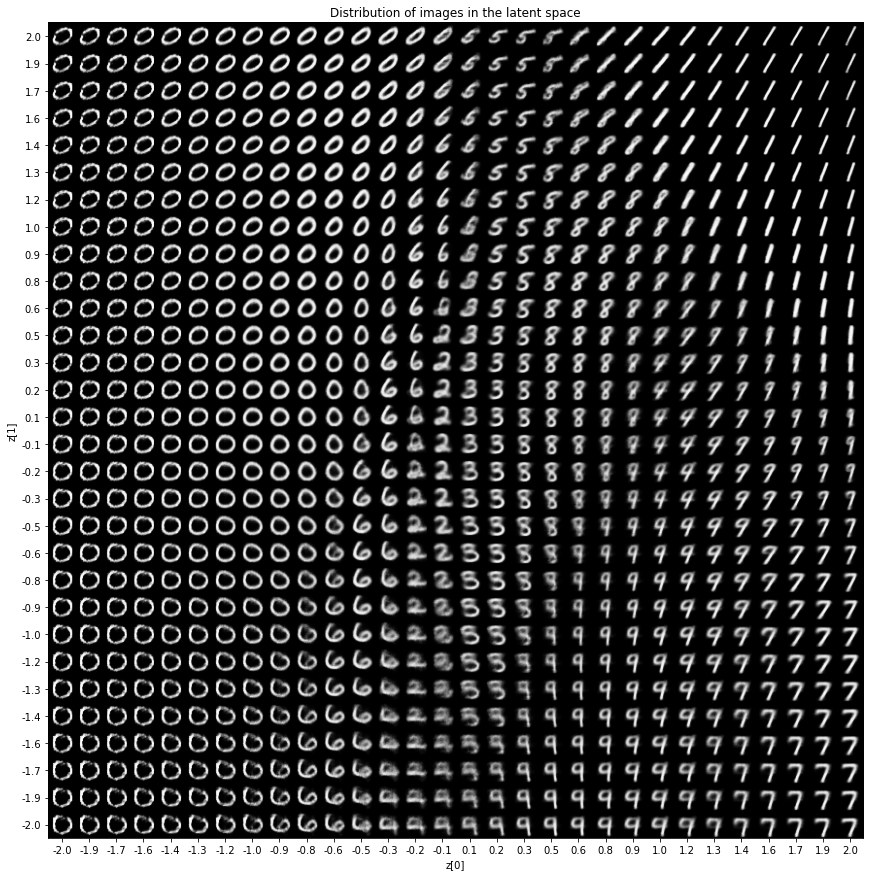

In [9]:
plot_latent(vae.encoder, vae.decoder)

The chart above is a plot of the section (-2;2)|(-2;2) of the latent space. Every 0.1 steps a point is chosen and decoded, the decoded version is shown in the plot. 

The smooth transition of features is clearly recognizable. For instance in (0.2;2) there is a clear "5" decoded. In (0.6;2) however, the "5" is stretched and deformed it transformes into a "1". Finally, in (0.9;1) the "1" is clearly recognizable. This regulary is achieved via the Variational Autoencoder.

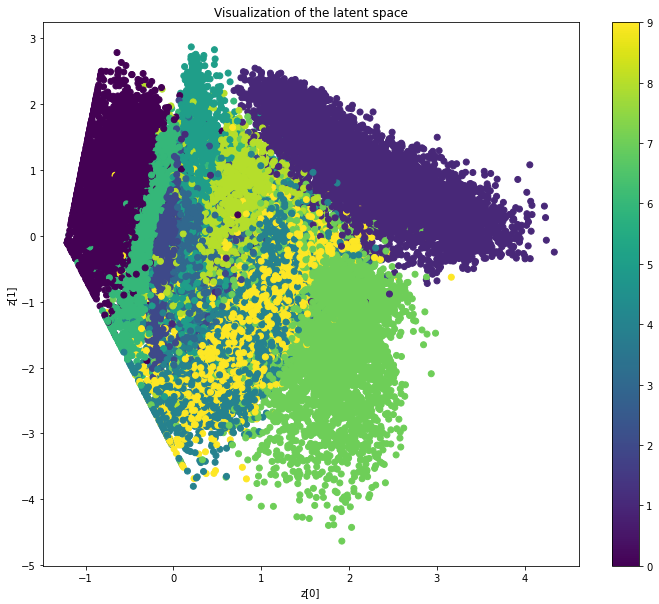

In [11]:
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae.encoder, vae.decoder, x_train, y_train)

In the scatterplot above, the distribution of points in the latent space is mapped. As you can see, clear clusters have formed, one per digit. Between the clusters, the images transition smoothly and make sense as well as they resemble malformed, but still readable numbers.